In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Bidirectional, Embedding)

In [16]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.head())
print(test.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


Part 1 Data EDA:
There are a lot of fields we dont care about, for test we only care about text, and for train we only care about text and target.

We will want to clean the text a bit including removing stop words and charectars we dont care about

In [17]:
#Remove the fields we dont want 
train = train.drop(['id', 'keyword', 'location'], axis=1)

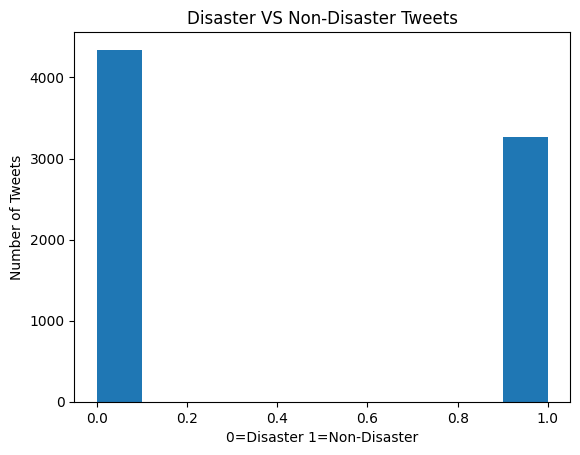

In [4]:
#make a histogram of the number of target 0's (disaster tweets) vs 1's (non-disaster tweets)

plt.hist(train["target"])
plt.title("Disaster VS Non-Disaster Tweets")
plt.xlabel("0=Disaster 1=Non-Disaster")
plt.ylabel("Number of Tweets")
plt.show()

In [4]:
#remove the stopwords from the text to avoid wasting time on words that dont alter the sentiment of the tweet that much
stopWordDict = stopwords.words('english')
def removeStopWords(text):
    new = []
    for i in text.split(" "):
        if i not in stopWordDict:
            new.append(i)
    final = " ".join(str(i) for i in new)
    return(final)

train["cleaned"] = train["text"].apply(removeStopWords)
test["cleaned"] = test["text"].apply(removeStopWords)

print(train.head())
print(test.head())

                                                text  target  \
0  Our Deeds are the Reason of this #earthquake M...       1   
1             Forest fire near La Ronge Sask. Canada       1   
2  All residents asked to 'shelter in place' are ...       1   
3  13,000 people receive #wildfires evacuation or...       1   
4  Just got sent this photo from Ruby #Alaska as ...       1   

                                             cleaned  
0  Our Deeds Reason #earthquake May ALLAH Forgive us  
1             Forest fire near La Ronge Sask. Canada  
2  All residents asked 'shelter place' notified o...  
3  13,000 people receive #wildfires evacuation or...  
4  Just got sent photo Ruby #Alaska smoke #wildfi...  
                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4    

In [8]:
#tokenize and then pad the scentences to allow the LSTM model to interpret them 

wordTokenizer = Tokenizer(num_words = 5000)
wordTokenizer.fit_on_texts(train["text"])
wordIndex = wordTokenizer.word_index

trainSequences = wordTokenizer.texts_to_sequences(train["text"])
trainPadded = pad_sequences(trainSequences, padding = "post")

testSequences = wordTokenizer.texts_to_sequences(test["text"])
testPadded = pad_sequences(testSequences, padding = "post", maxlen= trainPadded.shape[1])

print(trainPadded.shape, testPadded.shape)

(7613, 31) (3263, 31)


In [12]:
dim_size = 50

#create the model
model = Sequential([
    Embedding(5000, 31),
    Bidirectional(LSTM(dim_size, return_sequences = True)),
    Dropout(.2),
    Bidirectional(LSTM(dim_size, return_sequences = True)),
    Dropout(.2),
    Bidirectional(LSTM(dim_size)),
    Dropout(.2),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
#compile the model
from keras.metrics import F1Score
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score(threshold = 0.5)])

In [14]:
#train the model
model.fit(
    x = trainPadded,
    y = train["target"],
    epochs = 10
)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - f1_score: 0.5885 - loss: 0.5888
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.8250 - loss: 0.3418
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.8612 - loss: 0.2855
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.8983 - loss: 0.2347
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - f1_score: 0.9057 - loss: 0.2141
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9239 - loss: 0.1800
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9371 - loss: 0.1461
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9447 - loss: 0.1235
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9566 - loss: 0.1030
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - f1_score: 0.9549 - loss: 0.0919


Result:
Getting a model with my compute restrictions that can predict with a 95% accuracy whether or not a tweet is disaster related shows the power of LSTM models and comparing it to the last project shows just how much easier compute wise it is to create models to identify text VS images.

In [18]:
#create the test output for Kaggle
yPred = model.predict(testPadded)
yFinal = []
for val in yPred:
    if val >= 0.5:
        yFinal += [1]
    else:
        yFinal += [0]

test_id = pd.DataFrame(test["id"])
merged_df = pd.concat([test_id, pd.DataFrame(yFinal, columns=["target"])], axis=1)

merged_df.to_csv("output.csv", index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
